### Import Libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
from datetime import date
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error


import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import gc

import warnings
warnings.filterwarnings('ignore')

### Import Data

In [2]:
data = pd.read_csv('./data/Metro_Interstate_Traffic_Volume.csv', infer_datetime_format=True)

In [3]:
data['date_time'] =  pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')

In [4]:
data.describe(include = 'all')

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
count,48204,48204.000000,48204.000000,48204.000000,48204.000000,48204,48204,48204,48204.000000
unique,12,NaN,NaN,NaN,NaN,11,38,40575,NaN
top,None,NaN,NaN,NaN,NaN,Clouds,sky is clear,2013-05-19 10:00:00,NaN
freq,48143,NaN,NaN,NaN,NaN,15164,11665,6,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-10-02 09:00:00,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-09-30 23:00:00,NaN
mean,NaN,281.205870,0.334264,0.000222,49.362231,NaN,NaN,NaN,3259.818355
std,NaN,13.338232,44.789133,0.008168,39.015750,NaN,NaN,NaN,1986.860670
min,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000
25%,NaN,272.160000,0.000000,0.000000,1.000000,NaN,NaN,NaN,1193.000000


In [5]:
data = data.set_index(pd.DatetimeIndex(data['date_time'])).rename(columns={"date_time": "ds"}).drop_duplicates(subset=['ds'])

In [6]:
ts = data['2018-08-30':'2018-09-29']

In [7]:
ts.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,ds,traffic_volume
date_time,,,,,,,,,
2018-08-30 00:00:00,None,286.24,0.25,0.0,1,Rain,light rain,2018-08-30 00:00:00,670
2018-08-30 01:00:00,None,285.53,0.25,0.0,1,Rain,light rain,2018-08-30 01:00:00,456
2018-08-30 02:00:00,None,285.35,0.25,0.0,1,Rain,light rain,2018-08-30 02:00:00,326
2018-08-30 03:00:00,None,285.33,0.25,0.0,1,Rain,light rain,2018-08-30 03:00:00,388
2018-08-30 04:00:00,None,285.49,0.25,0.0,1,Rain,light rain,2018-08-30 04:00:00,1008


In [8]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2018-08-30 00:00:00 to 2018-09-29 23:00:00
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   holiday              744 non-null    object        
 1   temp                 744 non-null    float64       
 2   rain_1h              744 non-null    float64       
 3   snow_1h              744 non-null    float64       
 4   clouds_all           744 non-null    int64         
 5   weather_main         744 non-null    object        
 6   weather_description  744 non-null    object        
 7   ds                   744 non-null    datetime64[ns]
 8   traffic_volume       744 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 58.1+ KB


**Train/test Split**

In [9]:
split_date = '2018-09-22'
ts_train = ts.loc[ts.index <= split_date].copy()
ts_test = ts.loc[ts.index > split_date].copy()

In [10]:
len(ts_train), len(ts_test)

(553, 191)

**Stationnarity**

In [11]:
from statsmodels.tsa.stattools import adfuller
window = 24*7
cutoff = 0.05
def test_stationarity(timeseries, window = window, cutoff = cutoff):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(30, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 24 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

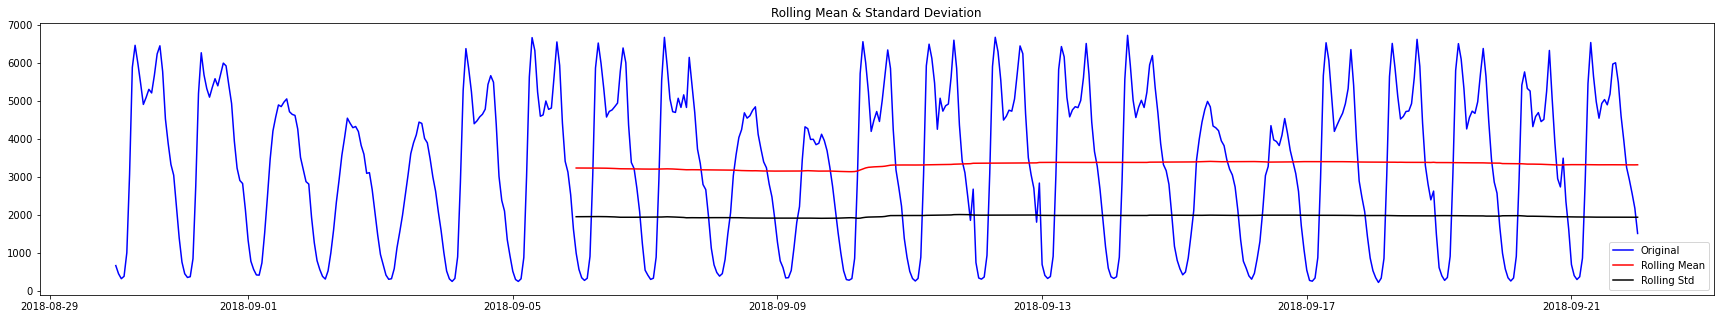

Results of Dickey-Fuller Test:
p-value = 0.0698. The series is likely non-stationary.
Test Statistic                  -2.725073
p-value                          0.069799
#Lags Used                      24.000000
Number of Observations Used    528.000000
Critical Value (1%)             -3.442796
Critical Value (5%)             -2.867030
Critical Value (10%)            -2.569694
dtype: float64


In [12]:
test_stationarity(ts_train.traffic_volume)

**Building a model**

In [13]:
# ACF and PACF plots
lag = 24
lag_pacf = pacf(ts_train.traffic_volume, nlags=lag, method='ols')
lag_acf = acf(ts_train.traffic_volume, nlags=lag)

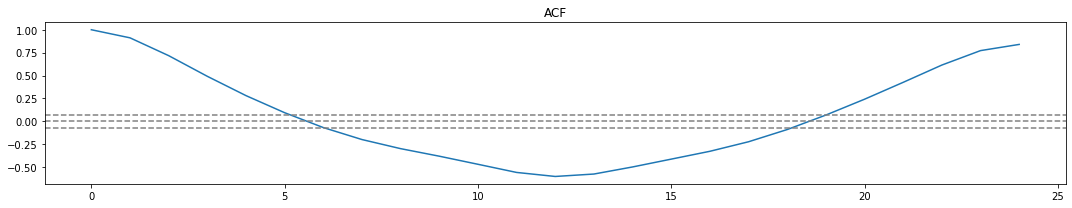

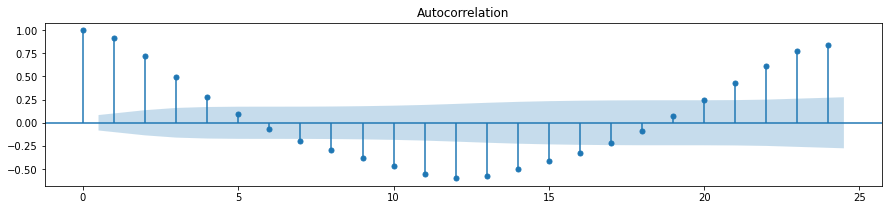

In [14]:
#Plot ACF: 
plt.figure(figsize=(15,3))
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('ACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,3))
plot_acf(ts_train.traffic_volume, ax=plt.gca(),lags=lag)
plt.show()

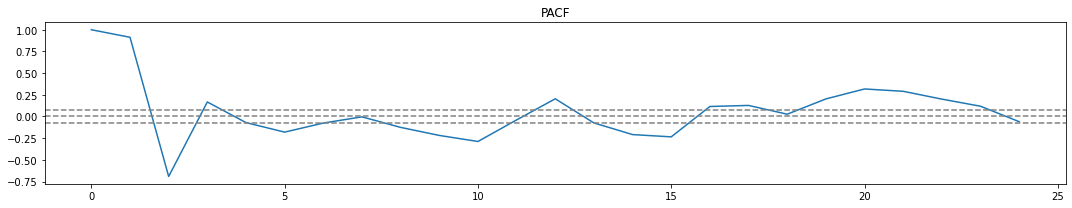

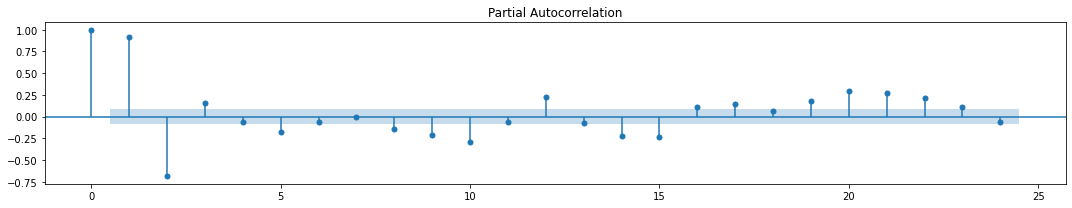

In [15]:
#Plot PACF:
plt.figure(figsize=(15,3))
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('PACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,3))
plot_pacf(ts_train.traffic_volume, ax=plt.gca(), lags=lag)
plt.tight_layout()
plt.show()

In [16]:
p=2
d=0
q=1

### ARIMA model

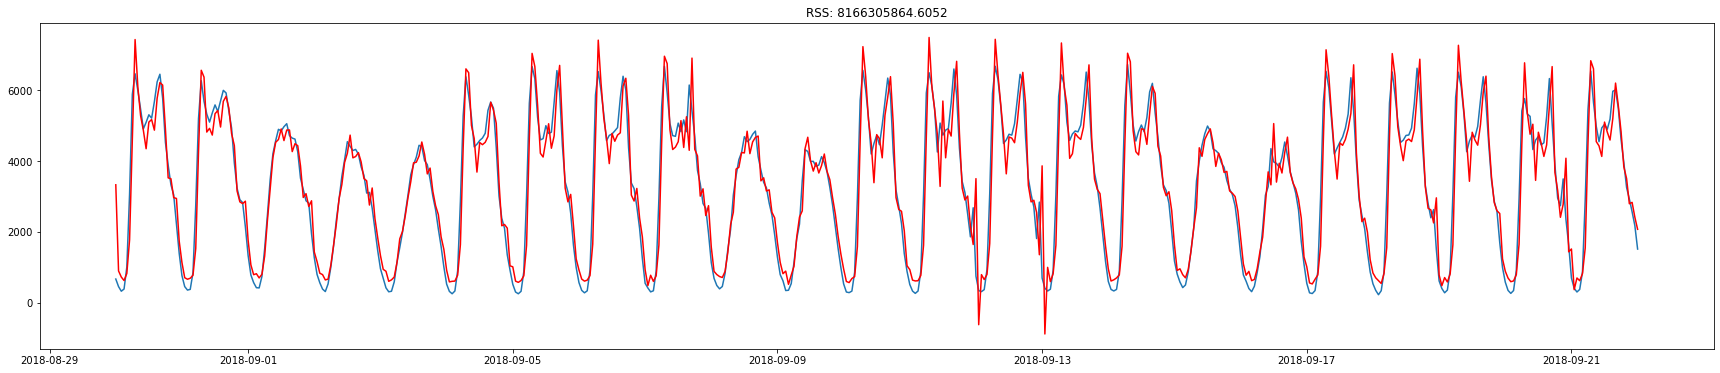

Wall time: 638 ms


In [17]:
%%time
# ARIMA
model = ARIMA(ts_train.traffic_volume, order=(p, d, q))  
#model = ARIMA(ts_train, order=(1, 0, 1)) 
results_ARIMA = model.fit(disp=1)
plt.figure(figsize=(30,6))
plt.plot(ts_train.traffic_volume)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues).dropna()**2))
plt.show()

In [18]:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         traffic_volume   No. Observations:                  553
Model:                     ARMA(2, 1)   Log Likelihood               -4294.078
Method:                       css-mle   S.D. of innovations            568.632
Date:                Tue, 15 Mar 2022   AIC                           8598.157
Time:                        16:00:11   BIC                           8619.734
Sample:                    08-30-2018   HQIC                          8606.587
                         - 09-22-2018                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 3330.8859    190.900     17.448      0.000    2956.728    3705.044
ar.L1.traffic_volume     1.4305      0.046     30.855      0.000       1.340       1.521
ar.L2.traffic_volume    -0.5860      0.045    -12.980      0.000      -0.674      -0.498
ma.L1.traffic_volume     0.2318      0.054      4.331      0.000       0.127       0.337
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2205           -0.4656j            1.3063           -0.0580
AR.2            1.2205           +0.4656j            1.3063            0.0580
MA.1           -4.3137           +0.0000j            4.3137            0.5000
-----------------------------------------------------------------------------
"""

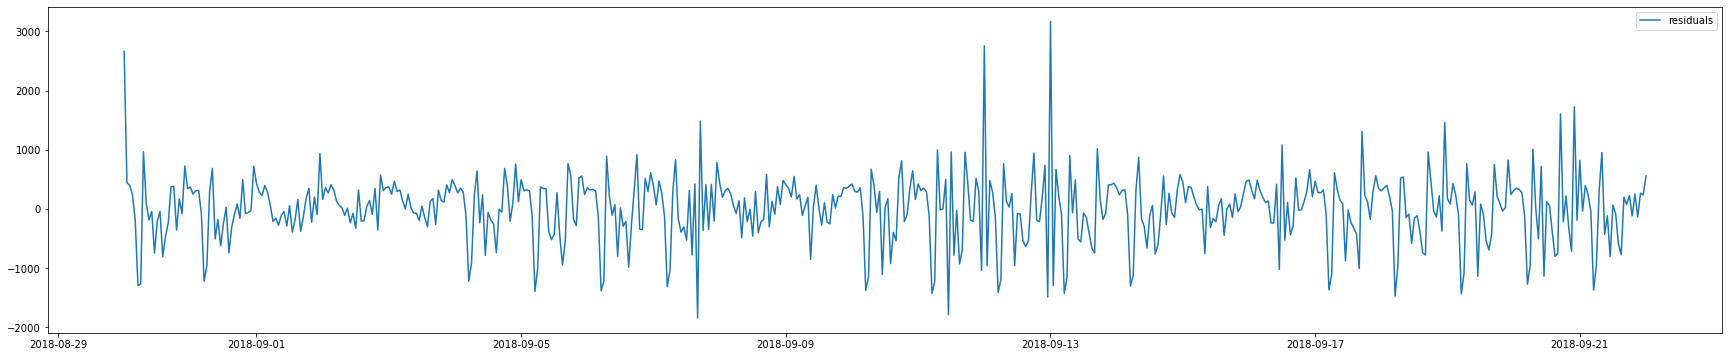

In [19]:
x = pd.DataFrame(results_ARIMA.fittedvalues)
x.columns = ['traffic_volume']
x = x.traffic_volume - ts_train.traffic_volume
plt.figure(figsize=(30,6))
plt.plot(x, label='residuals')
plt.legend(loc='best')
plt.show()

## Test ARIMA on testset

In [20]:
def StartARIMAForecasting(Actual, p, d, q):
    model = ARIMA(Actual, order=(p, d, q))
    model_fit = model.fit(disp=0)
    prediction = model_fit.forecast()[0]
    return prediction

In [21]:
len(ts_test.traffic_volume)

191

In [22]:
%%time
#new arrays to store actual and predictions
Actual = [x for x in ts_train.traffic_volume]
Predictions = list()

#in a for loop, predict values using ARIMA model
for timepoint in range(len(ts_test.traffic_volume)):
    ActualValue =  ts_test.traffic_volume[timepoint]
    #forcast value
    Prediction = StartARIMAForecasting(Actual, p,d,q)    
    print('Actual=%f, Predicted=%f' % (ActualValue, Prediction))
    #add it in the list
    Predictions.append(Prediction)
    Actual.append(ActualValue)  
 
predictions=pd.DataFrame(Predictions).set_index(ts_test.index)

Actual=1273.000000, Predicted=1280.343251
Actual=1207.000000, Predicted=1448.531285
Actual=611.000000, Predicted=1441.414221
Actual=647.000000, Predicted=486.654403
Actual=960.000000, Predicted=1117.084002
Actual=1635.000000, Predicted=1469.673219
Actual=2445.000000, Predicted=2327.834982
Actual=3415.000000, Predicted=3081.419914
Actual=3770.000000, Predicted=4046.736487
Actual=4308.000000, Predicted=3844.660226
Actual=4638.000000, Predicted=4577.682878
Actual=4831.000000, Predicted=4642.868597
Actual=4565.000000, Predicted=4755.410370
Actual=4654.000000, Predicted=4173.969287
Actual=4589.000000, Predicted=4611.674145
Actual=4582.000000, Predicted=4351.865582
Actual=4847.000000, Predicted=4437.940304
Actual=4620.000000, Predicted=4864.034838
Actual=4347.000000, Predicted=4233.790351
Actual=3602.000000, Predicted=4057.341653
Actual=2985.000000, Predicted=3019.372890
Actual=2480.000000, Predicted=2667.829808
Actual=1871.000000, Predicted=2271.017689
Actual=1249.000000, Predicted=1645.320

In [27]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [33]:
def error_metrics(y_true, y_pred):
    print('Mean Absolute Error: {:.2f}'.format(mean_absolute_error(y_true, y_pred)))
    print('Root Mean Squared Error: {:.2f}'.format(np.sqrt(mean_squared_error(y_true, y_pred))))
    print('Mean Absolute percentage Error: {:.2f} %'.format(mean_absolute_percentage_error(y_true, y_pred[0])))

In [35]:
#Calculate Model error
error_metrics(ts_test.traffic_volume, predictions)

Mean Absolute Error: 394.21
Root Mean Squared Error: 542.68
Mean Absolute percentage Error: 23.61 %


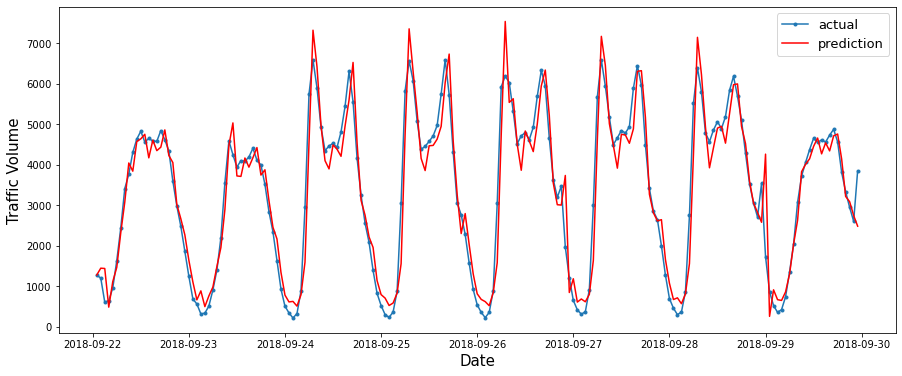

In [36]:
plt.figure(figsize=(15,6))
plt.plot(ts_test.index, pd.DataFrame(ts_test.traffic_volume), marker='.', label="actual")
plt.plot(ts_test.index, pd.DataFrame(Predictions)[0], 'r', label="prediction")
plt.ylabel('Traffic Volume', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=13)
plt.show()

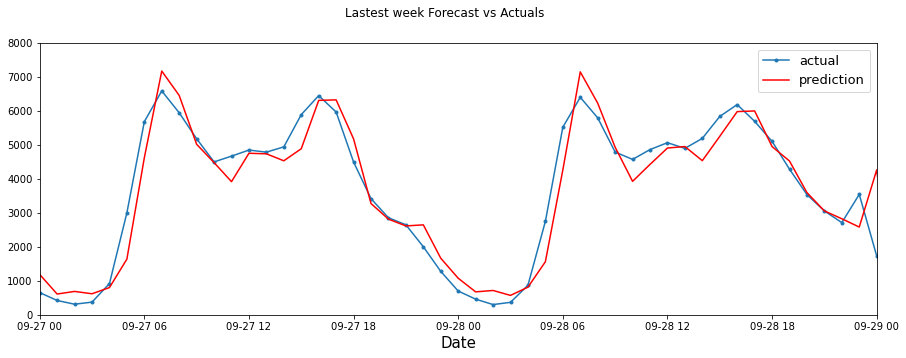

In [39]:
# zoom on lastest 2 days
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
plt.plot(ts_test.index, pd.DataFrame(ts_test.traffic_volume), marker='.', label="actual")
plt.plot(ts_test.index, pd.DataFrame(Predictions)[0], 'r', label="prediction")
ax.set_xbound(lower= datetime.date(2018,9,27), upper=datetime.date(2018,9,29))
plt.legend(fontsize=13)
plt.xlabel('Date', size=15)
ax.set_ylim(0, 8000)
plot = plt.suptitle('Lastest week Forecast vs Actuals')

### Auto Arima

In [ ]:
%%time
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(ts_train.traffic_volume, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3,  # maximum p and q
                      max_P=3, max_Q=3,  # maximum p and q
                      m=24,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # Seasonality
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                     n_fits = 50)

print(model.summary())

Performing stepwise search to minimize aic


In [ ]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

In [ ]:
y_pred = model.predict(len(ts_test))

In [ ]:
y_pred

In [ ]:
print('Test Mean Absolute Error:', mean_absolute_error(ts_test.traffic_volume, y_pred))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(ts_test.traffic_volume, y_pred)))
print('Test Mean Absolute percentage Error:',mean_absolute_percentage_error(ts_test.traffic_volume, y_pred))

In [ ]:
%%time
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(ts_train.traffic_volume,order=(p,d,q),seasonal_order=(p,d,q, 24))
results=model.fit()

In [ ]:
y_pred = pd.DataFrame(results.predict(len(ts_test)))

In [ ]:
y_pred

In [ ]:
len(ts_train), len(ts_test)